In [79]:
#import libraries
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import datetime as dt
import os
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
#import dataset & make a copy
os.getcwd()
os.chdir('/Users/ekaterinagalin/Desktop/IBM')

In [45]:
#import dataset
data = pd.read_csv('Supermarket Transactions.csv' )

#import dataset, containing imformation about margin
headers = ['Product Category', 'Margin']
margin = pd.read_excel ('margin.xlsx', names = headers, skiprows = 2)

df = data.copy()
df.head()

,Purchase Date,Customer ID,Gender,Marital Status,Homeowner,Children,Annual Income,City,State or Province,Country,Product Family,Product Department,Product Category,Units Sold,Revenue
0,18.12.12,7223,F,S,Y,2,$30K - $50K,Los Angeles,CA,USA,Food,Snack Foods,Snack Foods,5,$27.38
1,20.12.12,7841,M,M,Y,5,$70K - $90K,Los Angeles,CA,USA,Food,Produce,Vegetables,5,$14.90
2,21.12.12,8374,F,M,N,2,$50K - $70K,Bremerton,WA,USA,Food,Snack Foods,Snack Foods,3,$5.52
3,21.12.12,9619,M,M,Y,3,$30K - $50K,Portland,OR,USA,Food,Snacks,Candy,4,$4.44
4,22.12.12,1900,F,S,Y,3,$130K - $150K,Beverly Hills,CA,USA,Drink,Beverages,Carbonated Beverages,4,$14.00


In [93]:
#merge the two datasets
data_full = pd.merge(df, margin, how = 'left', on = ['Product Category'])

In [92]:
#remove $ sign & convert Revenue into float type
data_full['Revenue'] = data_full['Revenue'].astype(str)
data_full['Revenue'] = data_full['Revenue'].replace ({'\$': ''}, regex = True)
data_full['Revenue'] = data_full['Revenue'].astype(float)

In [50]:
#engineer new columns Profit & COGS
data_full['Profit'] = data_full['Revenue']* data_full['Margin']
data_full['CODS'] = data_full['Revenue'] - data_full['Profit']
data_full.shape

(14059, 18)

In [51]:
#convert Purchase Date column into datetime object
data_full['Purchase Date'] = pd.to_datetime(data_full['Purchase Date'], errors = 'coerce')

In [52]:
#save dataset
data_full.to_csv('python_transactions.csv', index = False)

In [53]:
#handle categorical vriables
custid = ['Customer ID']
data = ['Purchase Date']
target = ['Revenue']
num = ['Children', 'Revenue', 'Units Sold']

#store categorical column names
cat = np.array([x for x in df.columns if x not in custid + data + target + num])
cat

array(['Gender', 'Marital Status', 'Homeowner', 'Annual Income', 'City',
       'State or Province', 'Country', 'Product Family',
       'Product Department', 'Product Category'], dtype='<U18')

In [91]:
#handle categorical variables: create dummy variables
data = pd.get_dummies (data = data_full, columns = cat, drop_first = True)

In [55]:
#drop rows with null values (in Purcahse Date column)
data_null = data[data.isna().any(axis = 1)].index
data = data.drop (data_null)
data.shape

(14047, 118)

In [60]:
#assign values to X and y (target)
X = data.drop(labels = ['Revenue', 'Customer ID', 'Margin', 'Profit', 'CODS', 'Units Sold', 'Purchase Date'],axis = 1)
y = data['Revenue']

In [105]:
#split the data set into train & test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [149]:
#regression decision tree
from sklearn.tree import DecisionTreeRegressor

tree= DecisionTreeRegressor(random_state = 42, max_depth = 6, max_features = 0.8, min_samples_leaf = 10)
tree.fit(X_train, y_train)
y_pred = tree.predict (X_test)

In [150]:
print(tree.get_params())

{'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 6, 'max_features': 0.8, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 10, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 42, 'splitter': 'best'}


In [151]:
#assess performance of decision tree with RMSE
from sklearn.metrics import mean_squared_error

tree_mse = mean_squared_error(y_test, y_pred)
tree_rmse = np.sqrt(tree_mse)
print('Test set RMSE of decision tree: {:.2f}'.format(tree_rmse))

Test set RMSE of decision tree: 8.10


In [152]:
#K-fold cross-validation to overcome bias-variance problem
from sklearn.model_selection import cross_val_score

mse_cv = -cross_val_score(tree, X_train, y_train, cv = 10, scoring = 'neg_mean_squared_error', n_jobs = -1)
rmse_cv = np.sqrt(mse_cv)
tree.fit (X_train, y_train)
y_predict_train = tree.predict (X_train)
y_predict_test = tree.predict (X_test)

print('CV RMSE: {:.2f}'.format (rmse_cv.mean()))
print('Train MSE: {:.2f}'.format (np.sqrt(mean_squared_error(y_train, y_predict_train))))
print('Test MSE: {:.2f}'.format (np.sqrt(mean_squared_error(y_test, y_predict_test))))

CV RMSE: 8.11
Train MSE: 8.08
Test MSE: 8.10


In [147]:
#tune haperparameters of a decision tree
from sklearn.model_selection import GridSearchCV

params_grid = {
                'max_features': [0.2, 0.4, 0.6, 0.8],
                'min_samples_leaf': [0.1, 0.5, 1, 5, 10],
                'max_depth': [3, 4, 5, 6, 8, 10]
            }
    
grid_search = GridSearchCV(tree, param_grid = params_grid, cv=10,
                           scoring='neg_mean_squared_error', n_jobs= -1, return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=4, max_features=0.6,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=0.04,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=42, splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 8, 10],
                         'max_features': [0.2, 0.4, 0.6, 0.8],
                         'min_samples_leaf': [0.1, 0.5, 1, 5, 10]},
             p

In [148]:
#extract hyperparameters values
best_params = grid_search.best_params_
print('Best hyperparameters for decision tree:\n', best_params)

Best hyperparameters for decision tree:
 {'max_depth': 6, 'max_features': 0.8, 'min_samples_leaf': 10}


In [162]:
#best score from grod_search
best_cv_score = -grid_search.best_score_
print('Best CV RMSE: {:.2f}'.format(np.sqrt(best_cv_score)))

Best CV RMSE: 8.11


In [182]:
#bagging with Random Forests (ensemble)
#bootstrap samples are created with replacement
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features = 0.8, max_depth = 6, min_samples_leaf = 10)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict (X_test)

In [183]:
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test set RMSE of random forest: {:.2f}'.format(rmse_test_rf))

Test set RMSE of random forest: 8.10


In [ ]:
#assess feature importance (to reduce impurity)

importances_rf = pd.Series(rf.feature_importances_, index = X.columns)
sorted_importances_rf = importances_rf.sort_values(ascending = False).head(4)

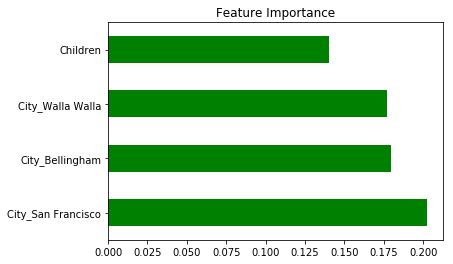

In [202]:
plt.title ('Feature Importance')
sorted_importances_rf.plot(kind = 'barh', color = 'green', fontsize = 10);
plt.show()

In [188]:
#tune haperparameters of a random forest
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
                'n_estimators': [20, 100, 150, 200, 300, 400],
                'max_features': ['log2', 'sqrt'],
                'min_samples_leaf': [0.1, 0.5, 1, 5, 10],
                'max_depth': [4, 6, 8, 10]
            }

grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5,
                           scoring='neg_mean_squared_error', verbose = 1, return_train_score=True, n_jobs = -1)
grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 236 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 486 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 836 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  5.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=6,
                                             max_features=0.8,
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=10,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1

In [190]:
#extract hyperparameters values
best_params_rf = grid_search.best_params_
print('Best hyperparameters for decision tree:\n', best_params_rf)

Best hyperparameters for decision tree:
 {'max_depth': 6, 'max_features': 0.8, 'min_samples_leaf': 10}


In [194]:
best_model = grid_search_rf.best_estimator_
y_pred = best_model.predict(X_test)
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test set RMSE of random forest: {:.2f}'.format(rmse_test_rf))

Test set RMSE of random forest: 8.09
